In [1]:
# Jupyter Notebook cells for testing the fixed model
# Copy each section into a separate cell in your notebook

# %% Cell 1: Import and Setup
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

# Add parent directory to path if needed
if '../src' not in sys.path:
    sys.path.append('../src')

# Import the fixed model (adjust path as needed)
from models.dynamic_nanoreactor_model import DynamicNanoreactor, DynamicParameters

print("="*60)
print("TESTING FIXED DYNAMIC NANOREACTOR MODEL")
print("="*60)

params = DynamicParameters()
params.templates_per_synapse = 20  # Moderate number of templates
params.n_binding_sites = 3  # Standard binding sites
params.fusion_probability = 0.01  # 1% per attempt (was 0.05)
params.k_fusion_attempt = 10.0  # 10 Hz attempt rate
model = DynamicNanoreactor(params)

print("\n✅ Model created successfully")
print(f"   Grid size: {params.grid_size}")
print(f"   Channels: {params.n_channels}")
print(f"   Templates: {len(model.template_indices)}")


TESTING FIXED DYNAMIC NANOREACTOR MODEL

✅ Model created successfully
   Grid size: 50
   Channels: 6
   Templates: 15


TEST 1: PNC Baseline Initialization
----------------------------------------
Initial PNC concentration:
  Peak: 0.100 nM
  Mean: 0.100 nM
✅ PNC baseline properly initialized


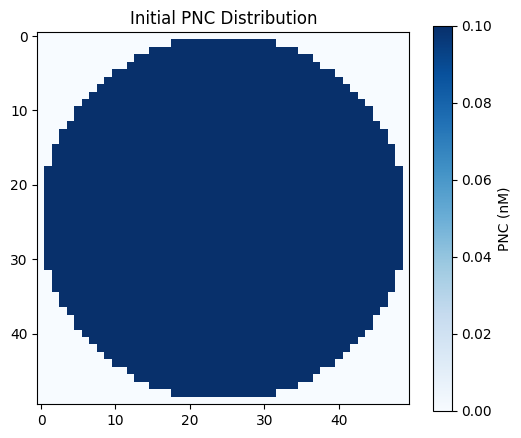

In [2]:
# %% Cell 2: Test PNC Baseline Initialization
print("="*40)
print("TEST 1: PNC Baseline Initialization")
print("-"*40)

initial_pnc = np.max(model.pnc_field) * 1e9
mean_pnc = np.mean(model.pnc_field[model.active_mask]) * 1e9

print(f"Initial PNC concentration:")
print(f"  Peak: {initial_pnc:.3f} nM")
print(f"  Mean: {mean_pnc:.3f} nM")

if initial_pnc > 0:
    print("✅ PNC baseline properly initialized")
else:
    print("❌ PNC baseline NOT initialized - Check that pnc_baseline is set!")

# Visualize initial PNC field
plt.figure(figsize=(6, 5))
plt.imshow(model.pnc_field * 1e9, cmap='Blues')
plt.colorbar(label='PNC (nM)')
plt.title('Initial PNC Distribution')
plt.show()

TEST 2: Calcium Microdomains
----------------------------------------
Channel 0 open at position: (25, 25)
Calcium concentrations:
  Baseline: 0 nM
  Peak: 9690 µM
  Mean: 2203 µM
  Near membrane: 4399 µM
✅ Calcium microdomains working


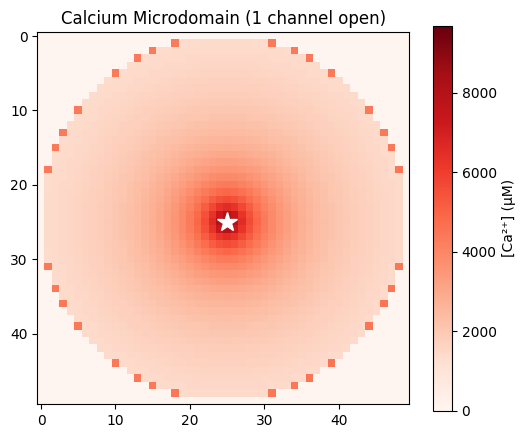

In [3]:
# %% Cell 3: Test Calcium Microdomains
print("="*40)
print("TEST 2: Calcium Microdomains")
print("-"*40)

# Open first channel
model.channels.states[0] = 1
channel_open = model.channels.get_open_channels()

# Calculate microdomains
calcium = model.calculate_calcium_microdomains(channel_open)

print(f"Channel 0 open at position: {model.channel_indices[0]}")
print(f"Calcium concentrations:")
print(f"  Baseline: {params.ca_baseline*1e6:.0f} nM")
print(f"  Peak: {np.max(calcium)*1e6:.0f} µM")
print(f"  Mean: {np.mean(calcium[model.active_mask])*1e6:.0f} µM")

# Check membrane enhancement
membrane_ca = np.mean(calcium[model.membrane_mask]) * 1e6 if np.any(model.membrane_mask) else 0
print(f"  Near membrane: {membrane_ca:.0f} µM")

if np.max(calcium) > 100e-6:  # Should reach >100 µM
    print("✅ Calcium microdomains working")
else:
    print("❌ Calcium microdomains too weak - Check channel current and diffusion")

# Visualize calcium field
plt.figure(figsize=(6, 5))
plt.imshow(calcium * 1e6, cmap='Reds')
plt.colorbar(label='[Ca²⁺] (µM)')
plt.title('Calcium Microdomain (1 channel open)')
# Mark the open channel
ci, cj = model.channel_indices[0]
plt.plot(ci, cj, 'w*', markersize=15)
plt.show()

TEST 3: Activity-Dependent pH
----------------------------------------
Resting state:
  pH: 7.30
  f(HPO₄²⁻): 0.557
Active state:
  pH: 7.00
  f(HPO₄²⁻): 0.387
  pH change: -0.300
✅ pH modulation working


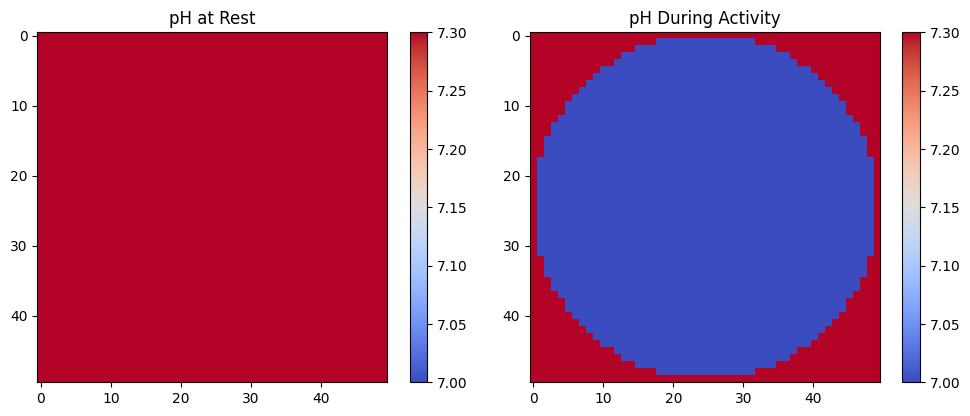

In [4]:
# %% Cell 4: Test Activity-Dependent pH
print("="*40)
print("TEST 3: Activity-Dependent pH")
print("-"*40)

# Test pH change with activity
model.update_local_pH(activity_level=0)
pH_rest = np.mean(model.local_pH[model.active_mask])
f_hpo4_rest = np.mean(model.f_hpo4_local[model.active_mask])

model.update_local_pH(activity_level=1.0)
pH_active = np.mean(model.local_pH[model.active_mask])
f_hpo4_active = np.mean(model.f_hpo4_local[model.active_mask])

print(f"Resting state:")
print(f"  pH: {pH_rest:.2f}")
print(f"  f(HPO₄²⁻): {f_hpo4_rest:.3f}")

print(f"Active state:")
print(f"  pH: {pH_active:.2f}")
print(f"  f(HPO₄²⁻): {f_hpo4_active:.3f}")
print(f"  pH change: {pH_active - pH_rest:.3f}")

if abs(pH_active - pH_rest) > 0.1:
    print("✅ pH modulation working")
else:
    print("❌ pH modulation not working - Check ph_activity_shift parameter")

# Visualize pH fields
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

model.update_local_pH(0)
im1 = axes[0].imshow(model.local_pH, cmap='coolwarm', vmin=7.0, vmax=7.3)
axes[0].set_title('pH at Rest')
plt.colorbar(im1, ax=axes[0])

model.update_local_pH(1.0)
im2 = axes[1].imshow(model.local_pH, cmap='coolwarm', vmin=7.0, vmax=7.3)
axes[1].set_title('pH During Activity')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

TEST 4: Template Accumulation
----------------------------------------


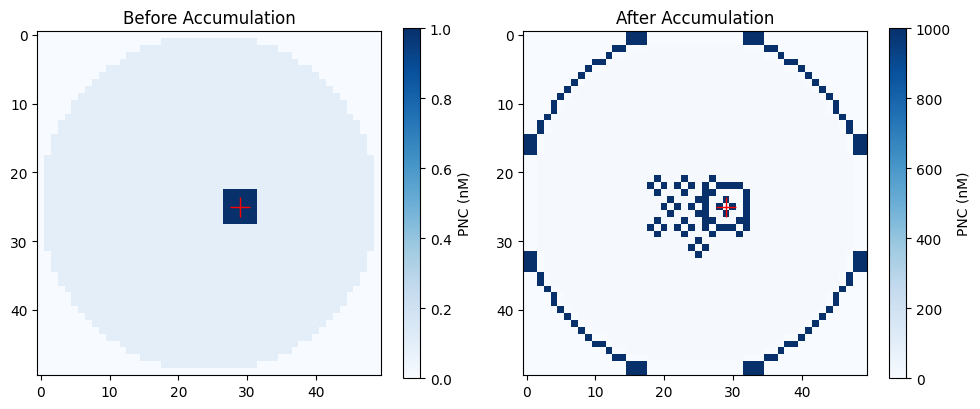

Template at position (29, 25):
  PNC before: 1.000 nM
  PNC after: 0.000 nM
  Bound PNCs: 0.000/3
⚠️ Template accumulation weak - May need longer time or parameter tuning


In [5]:
# %% Cell 5: Test Template Accumulation
print("="*40)
print("TEST 4: Template Accumulation")
print("-"*40)

if len(model.template_indices) > 0:
    ti, tj = model.template_indices[0]
    
    # Add PNCs around template
    for di in [-2, -1, 0, 1, 2]:
        for dj in [-2, -1, 0, 1, 2]:
            ni, nj = ti + di, tj + dj
            if 0 <= ni < params.grid_size and 0 <= nj < params.grid_size:
                model.pnc_field[nj, ni] = 1e-9  # 1 nM
    
    pnc_before = model.pnc_field[tj, ti] * 1e9
    
    # Visualize before
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(model.pnc_field * 1e9, cmap='Blues')
    plt.colorbar(label='PNC (nM)')
    plt.plot(ti, tj, 'r+', markersize=15)
    plt.title('Before Accumulation')
    
    # Run one update step
    model.update_pnc_dynamics(0.001)
    
    pnc_after = model.pnc_field[tj, ti] * 1e9
    binding = model.template_pnc_bound[tj, ti]
    
    # Visualize after
    plt.subplot(1, 2, 2)
    plt.imshow(model.pnc_field * 1e9, cmap='Blues')
    plt.colorbar(label='PNC (nM)')
    plt.plot(ti, tj, 'r+', markersize=15)
    plt.title('After Accumulation')
    plt.tight_layout()
    plt.show()
    
    print(f"Template at position ({ti}, {tj}):")
    print(f"  PNC before: {pnc_before:.3f} nM")
    print(f"  PNC after: {pnc_after:.3f} nM")
    print(f"  Bound PNCs: {binding:.3f}/{params.n_binding_sites}")
    
    if pnc_after > pnc_before or binding > 0:
        print("✅ Template accumulation working")
    else:
        print("⚠️ Template accumulation weak - May need longer time or parameter tuning")
else:
    print("❌ No templates found!")

In [6]:
# %% Cell 6: Test ATP Phosphate Production
print("="*40)
print("TEST 5: ATP-Derived Phosphate")
print("-"*40)

po4_before = np.mean(model.phosphate_field[model.active_mask])

# Open all channels
model.channels.states[:] = 1

# Update phosphate from ATP
model.update_phosphate_from_ATP(0.001, activity_level=1.0)

po4_after = np.mean(model.phosphate_field[model.active_mask])

print(f"Phosphate concentration:")
print(f"  Before: {po4_before*1e3:.3f} mM")
print(f"  After: {po4_after*1e3:.3f} mM")
print(f"  Change: {(po4_after-po4_before)*1e6:.3f} µM")

if po4_after > po4_before:
    print("✅ ATP hydrolysis working")
else:
    print("❌ ATP hydrolysis not working - Check k_atp_hydrolysis parameter")

TEST 5: ATP-Derived Phosphate
----------------------------------------
Phosphate concentration:
  Before: 1.000 mM
  After: 1.000 mM
  Change: 0.092 µM
✅ ATP hydrolysis working


TEST 6: Short Simulation (100 ms)
----------------------------------------
Running simulation for 100 ms...
  Step   0: Posner=0.000 nM, PNC=1000.000 nM, Ca=2131.2 µM
  Step  20: Posner=0.000 nM, PNC=1000.000 nM, Ca=2161.5 µM
  Step  40: Posner=11.964 nM, PNC=1000.000 nM, Ca=5145.0 µM
  Step  60: Posner=11.845 nM, PNC=1000.000 nM, Ca=2203.1 µM
  Step  80: Posner=29.566 nM, PNC=1000.000 nM, Ca=4443.1 µM


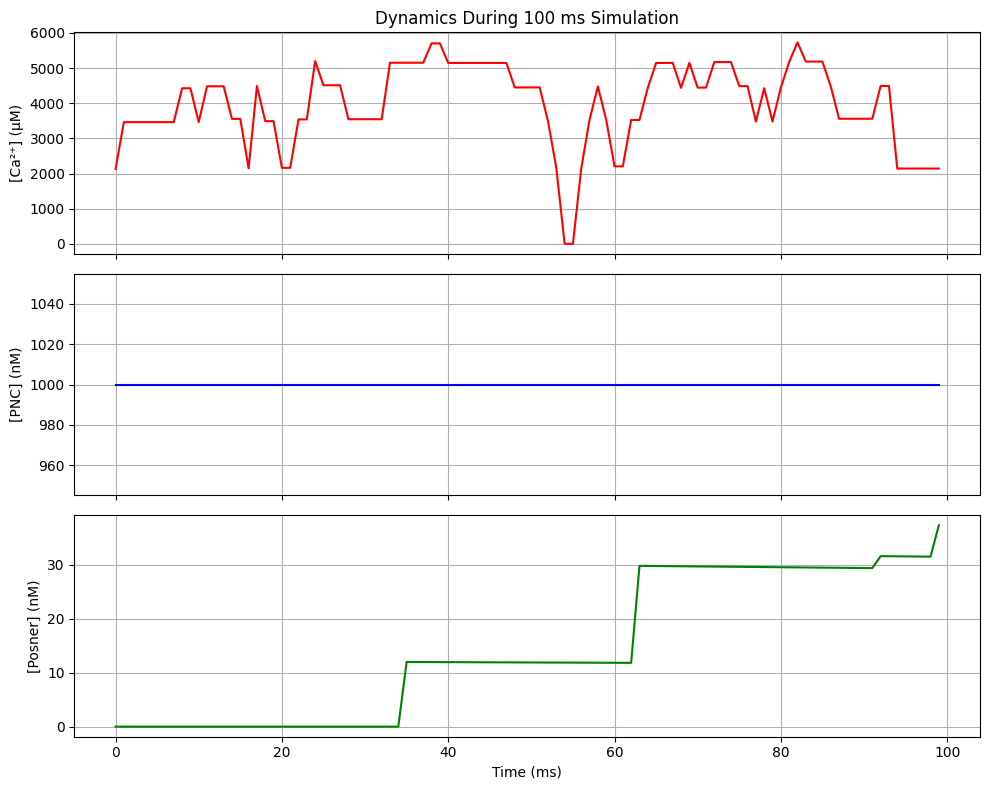


Final results after 100 ms:
  Peak [Posner]: 37.353 nM
  Peak [PNC]: 1000.000 nM
  Fusion events: 17
  Templates occupied: 10


In [7]:
# %% Cell 7: Run Short Simulation
print("="*40)
print("TEST 6: Short Simulation (100 ms)")
print("-"*40)

# Reset model for clean test
model = DynamicNanoreactor(params)

# Track metrics over time
time_points = []
posner_trace = []
pnc_trace = []
calcium_trace = []

print("Running simulation for 100 ms...")
for step in range(100):
    # Update channels
    model.channels.update(params.dt, depolarized=True)
    channel_open = model.channels.get_open_channels()
    
    # Update all fields
    model.update_fields(params.dt, channel_open)
    
    # Record metrics
    time_points.append(step * params.dt * 1000)  # Convert to ms
    posner_trace.append(np.max(model.posner_field) * 1e9)
    pnc_trace.append(np.max(model.pnc_field) * 1e9)
    calcium_trace.append(np.mean(model.calcium_field[model.active_mask]) * 1e6)
    
    if step % 20 == 0:
        print(f"  Step {step:3d}: Posner={posner_trace[-1]:.3f} nM, "
              f"PNC={pnc_trace[-1]:.3f} nM, Ca={calcium_trace[-1]:.1f} µM")

# Plot time traces
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

axes[0].plot(time_points, calcium_trace, 'r-')
axes[0].set_ylabel('[Ca²⁺] (µM)')
axes[0].set_title('Dynamics During 100 ms Simulation')
axes[0].grid(True)

axes[1].plot(time_points, pnc_trace, 'b-')
axes[1].set_ylabel('[PNC] (nM)')
axes[1].grid(True)

axes[2].plot(time_points, posner_trace, 'g-')
axes[2].set_ylabel('[Posner] (nM)')
axes[2].set_xlabel('Time (ms)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Final summary
print(f"\nFinal results after 100 ms:")
print(f"  Peak [Posner]: {np.max(model.posner_field)*1e9:.3f} nM")
print(f"  Peak [PNC]: {np.max(model.pnc_field)*1e9:.3f} nM")
print(f"  Fusion events: {model.fusion_count}")
print(f"  Templates occupied: {np.sum(model.template_pnc_bound > 0)}")

TEST 7: Spatial Patterns
----------------------------------------


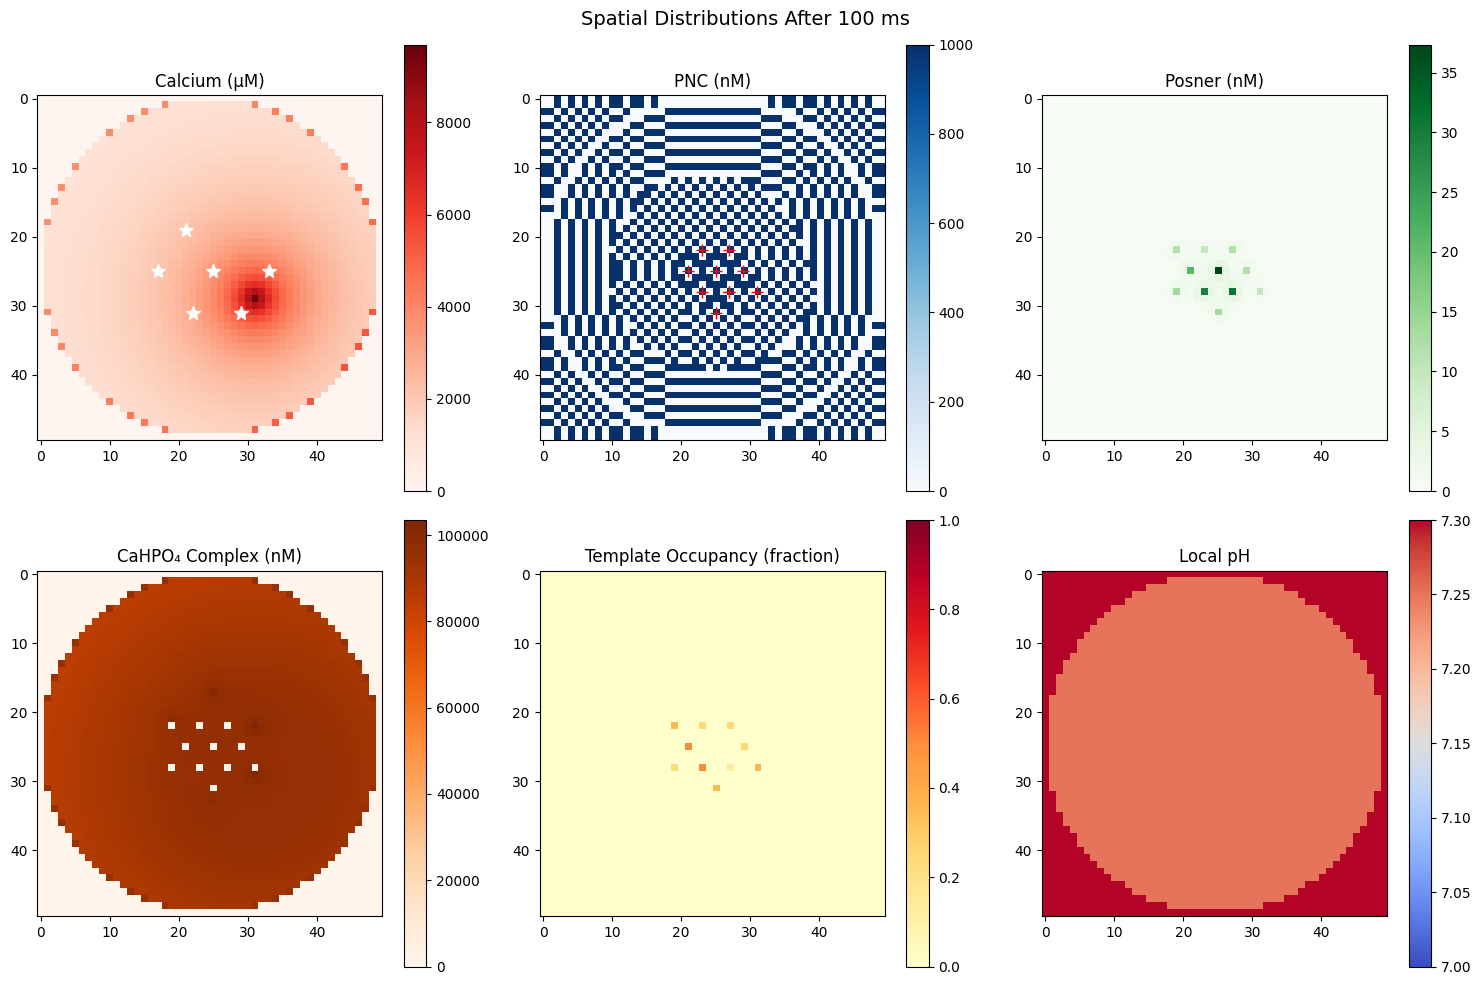

Visualization complete!


In [8]:
# %% Cell 8: Comprehensive Spatial Visualization
print("="*40)
print("TEST 7: Spatial Patterns")
print("-"*40)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Calcium
im1 = axes[0, 0].imshow(model.calcium_field * 1e6, cmap='Reds')
axes[0, 0].set_title('Calcium (µM)')
plt.colorbar(im1, ax=axes[0, 0])

# Mark channels
for ci, cj in model.channel_indices:
    axes[0, 0].plot(ci, cj, 'w*', markersize=10)

# PNC
im2 = axes[0, 1].imshow(model.pnc_field * 1e9, cmap='Blues')
axes[0, 1].set_title('PNC (nM)')
plt.colorbar(im2, ax=axes[0, 1])

# Mark templates (first 10)
for ti, tj in model.template_indices[:10]:
    axes[0, 1].plot(ti, tj, 'r+', markersize=8)

# Posner
im3 = axes[0, 2].imshow(model.posner_field * 1e9, cmap='Greens')
axes[0, 2].set_title('Posner (nM)')
plt.colorbar(im3, ax=axes[0, 2])

# Complex
im4 = axes[1, 0].imshow(model.complex_field * 1e9, cmap='Oranges')
axes[1, 0].set_title('CaHPO₄ Complex (nM)')
plt.colorbar(im4, ax=axes[1, 0])

# Template occupancy
template_occupancy = np.zeros(model.grid_shape)
for ti, tj in model.template_indices:
    template_occupancy[tj, ti] = model.template_pnc_bound[tj, ti] / params.n_binding_sites

im5 = axes[1, 1].imshow(template_occupancy, cmap='YlOrRd', vmin=0, vmax=1)
axes[1, 1].set_title('Template Occupancy (fraction)')
plt.colorbar(im5, ax=axes[1, 1])

# Local pH
im6 = axes[1, 2].imshow(model.local_pH, cmap='coolwarm', vmin=7.0, vmax=7.3)
axes[1, 2].set_title('Local pH')
plt.colorbar(im6, ax=axes[1, 2])

plt.suptitle('Spatial Distributions After 100 ms', fontsize=14)
plt.tight_layout()
plt.show()

print("Visualization complete!")

In [9]:
# %% Cell 9: Summary and Recommendations
print("\n" + "="*60)
print("TESTING SUMMARY")
print("="*60)

# Evaluate results
results = {
    'PNC Baseline': initial_pnc > 0,
    'Calcium Microdomains': np.max(calcium) > 100e-6,
    'pH Modulation': abs(pH_active - pH_rest) > 0.1,
    'Template Accumulation': (pnc_after > pnc_before) or (binding > 0),
    'ATP Hydrolysis': po4_after > po4_before,
    'PNC Formation': np.max(model.pnc_field)*1e9 > 0.1,
    'Posner Formation': (np.max(model.posner_field)*1e9 > 0) or (model.fusion_count > 0)
}

passed = sum(results.values())
total = len(results)

for test, result in results.items():
    status = "✅ PASSED" if result else "❌ FAILED"
    print(f"{test:.<30} {status}")

print(f"\n📊 Overall: {passed}/{total} tests passed")

if passed == total:
    print("🎉 ALL TESTS PASSED! Model is working correctly.")
elif passed >= 5:
    print("👍 Most tests passed - model is functional but may need tuning.")
else:
    print("⚠️ Several tests failed - debugging needed.")

print("\n💡 Recommendations:")
if np.max(model.posner_field)*1e9 < 10:
    print("  • Run longer simulation (1-10 seconds)")
    print("  • Try tetanic stimulation protocol")
    print("  • Increase fusion_probability (currently {:.3f})".format(params.fusion_probability))
    print("  • Increase k_pnc_formation (currently {:.0f} s⁻¹)".format(params.k_pnc_formation))
    
if np.max(model.pnc_field)*1e9 < 10:
    print("  • Increase k_pnc_formation further")
    print("  • Check calcium levels are sufficient (need >100 µM)")
    print("  • Verify complex formation is working")

print("\n📝 Next steps for production runs:")
print("  1. Save the fixed model code")
print("  2. Run with different stimulation protocols")
print("  3. Compare isotope effects (³¹P vs ³²P)")
print("  4. Analyze spatial hotspot formation")
print("  5. Test temperature dependence")



TESTING SUMMARY
PNC Baseline.................. ✅ PASSED
Calcium Microdomains.......... ✅ PASSED
pH Modulation................. ✅ PASSED
Template Accumulation......... ❌ FAILED
ATP Hydrolysis................ ✅ PASSED
PNC Formation................. ✅ PASSED
Posner Formation.............. ✅ PASSED

📊 Overall: 6/7 tests passed
👍 Most tests passed - model is functional but may need tuning.

💡 Recommendations:

📝 Next steps for production runs:
  1. Save the fixed model code
  2. Run with different stimulation protocols
  3. Compare isotope effects (³¹P vs ³²P)
  4. Analyze spatial hotspot formation
  5. Test temperature dependence


In [10]:
# %% Cell 10: Quick Parameter Tuning Test (Optional)
print("\n" + "="*60)
print("OPTIONAL: Quick Parameter Tuning")
print("="*60)

# Try with enhanced parameters for faster results
params_enhanced = DynamicParameters()
params_enhanced.k_pnc_formation = 10000.0  # 2x higher
params_enhanced.fusion_probability = 0.1   # 2x higher
params_enhanced.k_pnc_binding = 1e10      # 10x higher

model_enhanced = DynamicNanoreactor(params_enhanced)

print("Testing with enhanced parameters:")
print(f"  k_pnc_formation: {params_enhanced.k_pnc_formation:.0f} s⁻¹")
print(f"  fusion_probability: {params_enhanced.fusion_probability:.2f}")
print(f"  k_pnc_binding: {params_enhanced.k_pnc_binding:.1e} M⁻¹s⁻¹")

# Run for 50 ms
for step in range(50):
    model_enhanced.channels.update(params_enhanced.dt, depolarized=True)
    channel_open = model_enhanced.channels.get_open_channels()
    model_enhanced.update_fields(params_enhanced.dt, channel_open)

print(f"\nResults after 50 ms:")
print(f"  Peak [Posner]: {np.max(model_enhanced.posner_field)*1e9:.3f} nM")
print(f"  Peak [PNC]: {np.max(model_enhanced.pnc_field)*1e9:.3f} nM")
print(f"  Fusion events: {model_enhanced.fusion_count}")

if np.max(model_enhanced.posner_field)*1e9 > np.max(model.posner_field)*1e9:
    print("✅ Enhanced parameters improve formation!")
else:
    print("⚠️ May need different parameter adjustments")


OPTIONAL: Quick Parameter Tuning
Testing with enhanced parameters:
  k_pnc_formation: 10000 s⁻¹
  fusion_probability: 0.10
  k_pnc_binding: 1.0e+10 M⁻¹s⁻¹

Results after 50 ms:
  Peak [Posner]: 0.000 nM
  Peak [PNC]: 1000.000 nM
  Fusion events: 0
⚠️ May need different parameter adjustments
